In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import k3d
import numpy as np
import matplotlib.pyplot as plt
import h5py
import sys
import tqdm

In [3]:
import torch
from torch.utils.data import DataLoader

In [4]:
from sharpf.data.datasets.sharpf_io import PointCloudIO, DepthMapIO
from sharpf.utils.abc_utils.hdf5.dataset import LotsOfHdf5Files, Hdf5File
from sharpf.utils.abc_utils.torch import *
from sharpf.utils.plotting import display_depth_sharpness

from sharpf.utils.camera_utils.camera_pose import camera_to_display, CameraPose
from sharpf.data.imaging import IMAGING_BY_TYPE
from sharpf.utils.py_utils.config import load_func_from_config

In [5]:
def display_sharpness(mesh=None, plot_meshvert=True,
                      samples=None, samples_distances=None,
                      sharp_vert=None, sharp_curves=None,
                      directions=None, directions_width=0.0025,
                      samples_color=0x0000ff, samples_psize=0.002, 
                      mesh_color=0xbbbbbb, meshvert_color=0x666666, meshvert_psize=0.0025,
                      sharpvert_color=0xff0000, sharpvert_psize=0.0025,
                      sharpcurve_color=None, sharpcurve_width=0.0025,
                      as_image=False, plot_height=768, 
                      cmap_distances=k3d.colormaps.basic_color_maps.WarmCool,
                      distance_range=None):
    
    plot = k3d.plot(height=plot_height, camera_fov=30.0)
    
    if None is not mesh:
        k3d_mesh = k3d.mesh(mesh.vertices, mesh.faces, color=mesh_color)
        plot += k3d_mesh

        if plot_meshvert:
            k3d_points = k3d.points(mesh.vertices, 
                                    point_size=meshvert_psize, color=meshvert_color)
            plot += k3d_points
            k3d_points.shader='flat'

    if None is not samples:
        colors = None
        if None is not samples_distances:
            if None is distance_range:
                distance_range = [0, np.max(samples_distances)]

            colors = k3d.helpers.map_colors(
                samples_distances, cmap_distances, distance_range
            ).astype(np.uint32)
            k3d_points = k3d.points(samples, point_size=samples_psize, colors=colors)
        else:
            k3d_points = k3d.points(samples, point_size=samples_psize, color=samples_color)
        plot += k3d_points
        k3d_points.shader='flat'
        
        if None is not directions:
            directions_to_plot = np.hstack((samples, samples + directions))
            
            for i, dir_to_plot in enumerate(directions_to_plot):
                dir_to_plot = dir_to_plot.reshape((2, 3))
                if np.all(dir_to_plot[0] == dir_to_plot[1]):
                    continue
                color = int(colors[i]) if None is not colors else samples_color
                plt_line = k3d.line(dir_to_plot, 
                                    shader='mesh', width=directions_width, color=color)
                plot += plt_line

    if None is not sharp_vert:
        k3d_points = k3d.points(sharp_vert,
                                point_size=sharpvert_psize, color=sharpvert_color)
        plot += k3d_points
        k3d_points.shader='flat'
        
        if None is not sharp_curves:            
            if None is not sharpcurve_color:
                color = sharpcurve_color
            else:
                import randomcolor
                rand_color = randomcolor.RandomColor()
            for i, vert_ind in enumerate(sharp_curves):
                sharp_points_curve = mesh.vertices[vert_ind]
                
                if None is sharpcurve_color:
                    color = rand_color.generate(hue='red')[0]
                    color = int('0x' + color[1:], 16)
                plt_line = k3d.line(sharp_points_curve, 
                                    shader='mesh', width=sharpcurve_width, color=color)
                plot += plt_line
        
    plot.grid_visible = False
    plot.camera_auto_fit = True
    plot.display()
    
    return plot

In [6]:
!ls /logs

abc_0000_1_2.hdf5	 abc_0056_0_1.hdf5
abc_0000_7130_7140.hdf5  abc_0056_0_1_lowre.hdf5


## Creating the dataset and observing it

In [8]:
# transform = CompositeSharpnessTransform([
#     TypeCast(torch.float32, torch.float32),
#     Center(),
#     NormalizeL2(),
#     Random3DRotation(),
# #     RandomSubsamplePoints(1024, 3.0),
# ])

In [11]:
# hdf5_input_dir = '/logs/points'
data_label = 'image'
target_label = 'distances'
# labels = ['directions', 'distances', 'has_sharp', 
#           'item_id', 'normals', 'num_sharp_curves', 
#           'num_surfaces', 'orig_face_indexes', 'orig_vert_indices', 'points']
labels = '*'
# labels = ['points',
#           'num_sharp_curves', 
#           'num_surfaces',
#           'camera_pose']

# dataset = LotsOfHdf5Files(
#         data_dir=hdf5_input_dir,
#         io=DepthIO,
#         data_label=data_label,
#         target_label=target_label,
#         labels=labels,
#         max_loaded_files=10)

dataset = Hdf5File(
    '/logs/abc_0000_7130_7140.hdf5',
    io=DepthMapIO,
    data_label=data_label,
    target_label=target_label,
    labels='*',
    transform=None)
len(dataset)

3101

In [21]:
images = np.array([camera_to_display(dataset[idx]['image'].numpy())
                   for idx in range(len(dataset))])
distances = np.array([camera_to_display(dataset[idx]['distances'].numpy())
                      for idx in range(len(dataset))])
camera_poses = [CameraPose(dataset[idx]['camera_pose'])  
               for idx in range(len(dataset))]

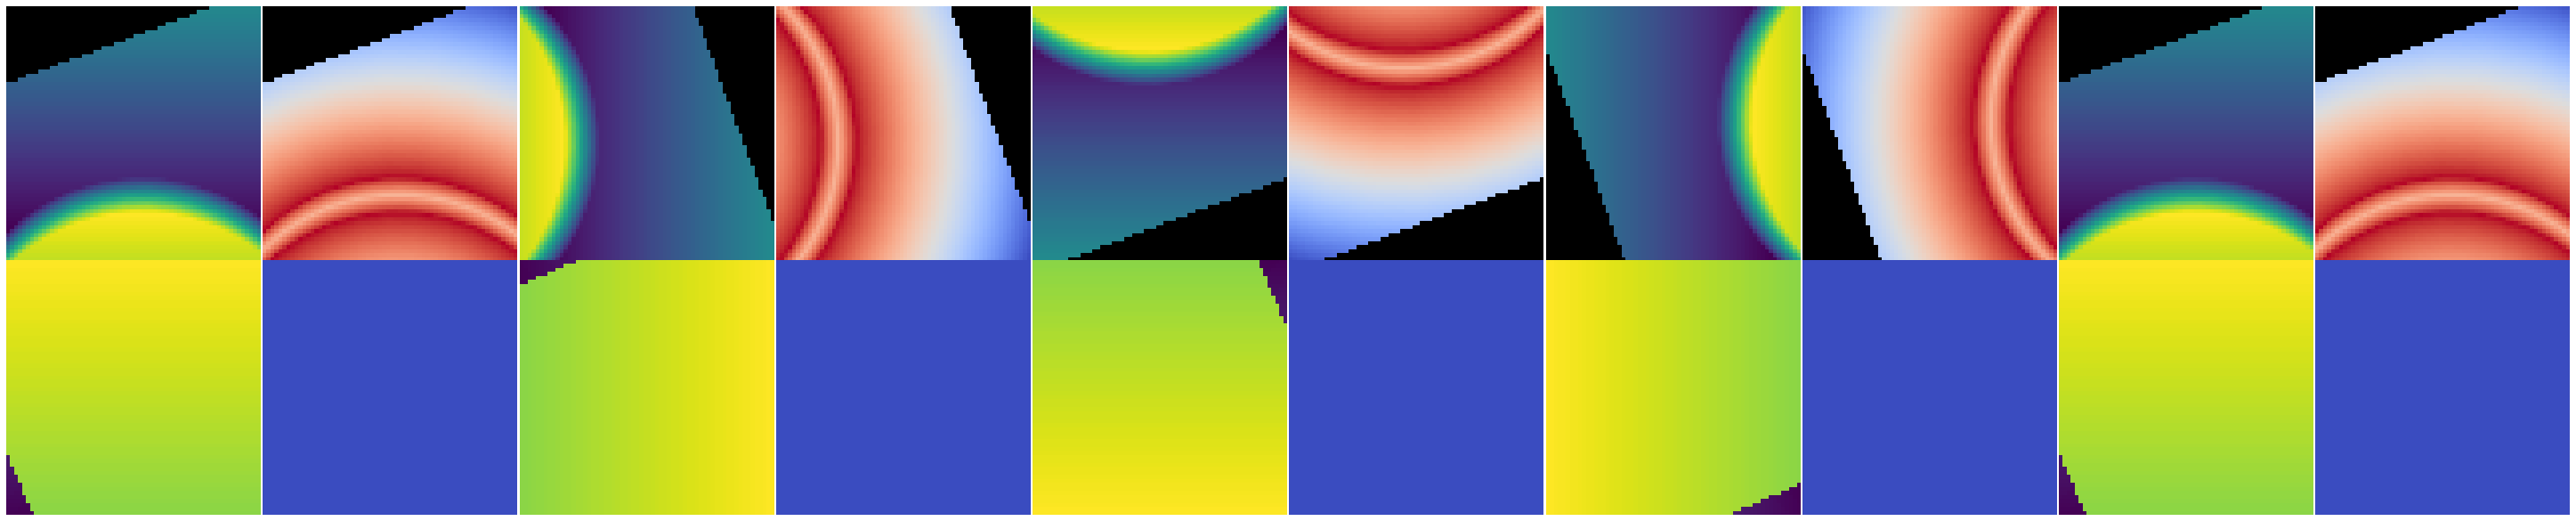

In [48]:
idx = np.random.choice(np.arange(len(images)), replace=False, size=80)

display_depth_sharpness(
    depth_images=images[440:450],
    sharpness_images=distances[440:450],
    axes_size=(4, 4),
    ncols=5
)

## Viewing depth images in 3D

In [60]:
import json
with open('/code/scripts/data_scripts/configs/depthmap_datasets/dataset_config_high_res_clean_64x64.json') as config_file:
    config = json.load(config_file)

config

{'shape_fabrication_extent': 10.0,
 'short_curve_quantile': 0.25,
 'base_n_points_per_short_curve': 8,
 'base_resolution_3d': 0.125,
 'camera_pose': {'type': 'composite',
  'sequences': [{'type': 'sphere_to_origin', 'n_images': 10},
   {'type': 'xy_translation', 'n_images': 100},
   {'type': 'z_rotation', 'n_images': 5}]},
 'imaging': {'type': 'raycasting',
  'projection': 'ortho',
  'resolution_image': 64,
  'resolution_3d': 0.02,
  'fov': [115, 85, 80],
  'validate_image': True},
 'noise': {'type': 'many_noisers', 'subtype': 'z_direction', 'scale': [0.0]},
 'annotation': {'type': 'surface_based_aabb',
  'distance_upper_bound': 1.0,
  'validate_annotation': True}}

In [61]:
imaging = load_func_from_config(IMAGING_BY_TYPE, config['imaging'])

In [62]:
idx = 440

camera_pose = camera_poses[idx]
image = images[idx]
sharpness = distances[idx]

In [69]:
points = camera_pose.camera_to_world(imaging.image_to_points(image))

In [70]:
display_sharpness(
    None, plot_meshvert=True, meshvert_psize=imaging.resolution_3d / 2,
#     sharp_vert=camera_pose.camera_to_world(imaging.rays_origins), sharpvert_psize=0.5,
    samples=points, samples_psize=imaging.resolution_3d,
    samples_distances=sharpness[np.where(image != 0)]
)

/home/user/miniconda/envs/py36/lib/python3.6/site-packages/traittypes/traittypes.py:101: UserWarning: Given trait value dtype "float64" does not match required type "float32". A coerced copy has been created.
  np.dtype(self.dtype).name))


Output()

Plot(antialias=3, axes=['x', 'y', 'z'], axes_helper=1.0, background_color=16777215, camera=[4.5, 4.5, 4.5, 0.0…

## Dataloading with augmentations with DataLoader

In [73]:
# hdf5_input_dir = '/logs/points'
data_label = 'image'
target_label = 'distances'
# labels = ['directions', 'distances', 'has_sharp', 
#           'item_id', 'normals', 'num_sharp_curves', 
#           'num_surfaces', 'orig_face_indexes', 'orig_vert_indices', 'points']
# labels = '*'
# labels = ['points',
#           'num_sharp_curves', 
#           'num_surfaces',
#           'camera_pose']

# dataset = LotsOfHdf5Files(
#         data_dir=hdf5_input_dir,
#         io=DepthIO,
#         data_label=data_label,
#         target_label=target_label,
#         labels=labels,
#         max_loaded_files=10)

dataset = Hdf5File(
    '/logs/abc_0000_7130_7140.hdf5',
    io=DepthMapIO,
    data_label=data_label,
    target_label=target_label,
    labels=None,
    transform=None)
len(dataset)

3101

In [74]:
batch_size = 16
train_loader = DataLoader(
    dataset,
    num_workers=4,
    batch_size=batch_size,
    shuffle=False,
)

In [75]:
for batch in tqdm.tqdm(train_loader):
    pass

100%|██████████| 194/194 [00:00<00:00, 537.34it/s]
